In [17]:
import pandas as pd
import numpy as np
from path import Path


### Load binding data for target protein and clean up as array ###
# Read CSV data file (data saved as normalized binding scores in two columns)
BindDF = pd.read_csv("FGF2.csv", header = 0, index_col = 0)

# Convert pd dataframe to np array
BindArray = BindDF.to_numpy()


### Load Sulfation Identity Array (SFA) ###
# Load SF dataframe (SFDF) - provides N-sulfation, 6-sulfation and 2-sulfation encoded
# as binary in columns 1, 2, 3, 4, 5, and 6, respectively
SFDF = pd.read_csv("Sulfated Matrix.csv", index_col = 0)

# convert pd dataframe to np array
SFA = SFDF.to_numpy()


### Calculate Sulfation Frequency Matrix (SFM) ###
SFM = np.multiply(BindArray, SFA)


### Calculate position frequency (PF) and number of binding events
PF = [sum(x) for x in zip(*SFM)]
BindingEvents = [sum(x) for x in zip(*BindArray)]


### Calculate position frequency matrix (PFM)
PFM = np.asarray(PF)
BindingEvents = np.asarray(BindingEvents)
FrequencyMatrix = np.divide(PFM, BindingEvents)


### Calculate position weight matrix (PWM) and log likeliness (LogLike)
PWM = FrequencyMatrix/0.5
LogLike = np.log2(PWM)

In [18]:
### Load Unsulfated Identity Array (UFA) ###
# Load SF dataframe (UFDF) - provides N-sulfation, 6-sulfation and 2-sulfation encoded
# as binary in columns 1, 2, 3, 4, 5, and 6, respectively
UFDF = pd.read_csv("Unsulfated Matrix.csv", index_col = 0)

# convert pd dataframe to np array
UFA = UFDF.to_numpy()


### Calculate Unsulfated Frequency Matrix (UFM) ###
UFM = np.multiply(BindArray, UFA)


### Calculate unsulfated position frequency (UPF) and number of binding events
UPF = [sum(y) for y in zip(*UFM)]


### Calculate position frequency matrix for unsulfation (UPFM)
UPFM = np.asarray(UPF)
FrequencyMatrix_U = np.divide(UPF, BindingEvents)

### Calculate position weight matrix (PWM_U) and log likeliness (LogLike_U) for unsulfation
PWM_U = FrequencyMatrix_U/0.5
LogLike_U = np.log2(PWM_U)

In [19]:
import math
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
import PIL.ImageColor 

### Define text and graph call functions
### Only the called font should be changed here as desired - will be unique to user
def text_draw_np(text, width, height, *, font = 'c:/windows/fonts/Arialbd.ttf', bg = (255, 255, 255), color = (0, 0, 0), remove_gaps = False, cache = {}):
    def get_font(fname, size):
        key = ('font', fname, size)
        if key not in cache:
            cache[key] = PIL.ImageFont.truetype(fname, size = size, encoding = 'unic')
        return cache[key]
    width, height = math.ceil(width), math.ceil(height)
    pil_font = get_font(font, 24)
    text_width, text_height = pil_font.getsize(text)
    pil_font = get_font(font, math.ceil(1.2 * 24 * max(width / text_width, height / text_height)))
    text_width, text_height = pil_font.getsize(text)
    canvas = PIL.Image.new('RGB', (text_width, text_height), bg)
    draw = PIL.ImageDraw.Draw(canvas)
    draw.text((0, 0), text, font = pil_font, fill = color)
    if remove_gaps:
        a = np.asarray(canvas)
        bg_rgb = PIL.ImageColor.getrgb(bg)
        b = np.zeros_like(a)
        b[:, :, 0] = bg_rgb[0]; b[:, :, 1] = bg_rgb[1]; b[:, :, 2] = bg_rgb[2]
        t0 = np.any((a != b).reshape(a.shape[0], -1), axis = -1)
        top, bot = np.flatnonzero(t0)[0], np.flatnonzero(t0)[-1]
        t0 = np.any((a != b).transpose(1, 0, 2).reshape(a.shape[1], -1), axis = -1)
        lef, rig = np.flatnonzero(t0)[0], np.flatnonzero(t0)[-1]
        a = a[top : bot, lef : rig]
        canvas = PIL.Image.fromarray(a)
    canvas = canvas.resize((width, height), PIL.Image.LANCZOS)
    return np.asarray(canvas)
    
def text_draw_mpl(fig, ax, text, offset_x, offset_y, width, height, **nargs):
    axbb = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    pxw, pxh = axbb.width * fig.dpi * width / (ax.get_xlim()[1] - ax.get_xlim()[0]), axbb.height * fig.dpi * height / (ax.get_ylim()[1] - ax.get_ylim()[0])
    ax.imshow(text_draw_np(text, pxw * 1.2, pxh * 1.2, **nargs), extent = (offset_x, offset_x + width, offset_y, offset_y + height), aspect = 'auto', interpolation = 'lanczos')

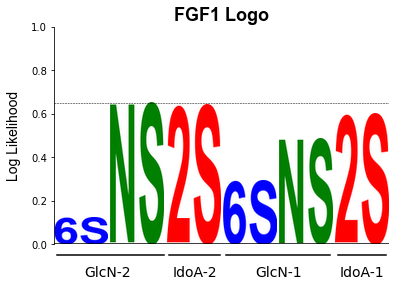

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

### Set axis limits - these values should not be changed
# Current figure scale is for overrepresented motifs. If the user wishes to display underrepresented motifs, the 'xlim' 
# values may be set to negative values.
ax.set_ylim((0), (1.0))
ax.set_xlim(0, 625)

### In list 'LogLike', the following indices correspond to values as listed:
###     LogLike[1] is log likelihood of 6-O-sulfation @ non-reducing end GlcN
###     LogLike[0] is log likelihood of N-sulfation @ non-reducing end GlcN
###     LogLike[2] is log likelihood of 2-O-sulfation @ non-reducing end IdoA
###     LogLike[4] is log likelihood of 6-O-sulfation @ reducing end GlcN
###     LogLike[3] is log likelihood of N-sulfation @ reducing end GlcN
###     LogLike[5] is log likelihood of 2-O-sulfation @ reducing end IdoA
A = LogLike[1]
B = LogLike[0]
C = LogLike[2]
D = LogLike[4]
E = LogLike[3]
F = LogLike[5]

### In list 'LogLike_U', the following indices correspond to values as listed:
###     LogLike_U[1] is log likelihood of 6-O-sulfation @ non-reducing end GlcN
###     LogLike_U[0] is log likelihood of N-sulfation @ non-reducing end GlcN
###     LogLike_U[2] is log likelihood of 2-O-sulfation @ non-reducing end IdoA
###     LogLike_U[4] is log likelihood of 6-O-sulfation @ reducing end GlcN
###     LogLike_U[3] is log likelihood of N-sulfation @ reducing end GlcN
###     LogLike_U[5] is log likelihood of 2-O-sulfation @ reducing end IdoA
G = LogLike_U[1]
H = LogLike_U[0]
I = LogLike_U[2]
J = LogLike_U[4]
K = LogLike_U[3]
L = LogLike_U[5]


### Draw '6S' for 6-O-sulfation of non-reducing end glucosamine
if A > 0:
    text_draw_mpl(fig, ax, '6S', 0, 0, 100, A, color = 'blue', bg = 'white', remove_gaps = True)
elif A == 0:
    null        
else:
    text_draw_mpl(fig, ax, '6S', 0, A, 100, abs(A), color = 'blue', bg = 'white', remove_gaps = True)

    
### Draw 'NS' for N-sulfation of non-reducing end glucosamine        
if B > 0:
    text_draw_mpl(fig, ax, 'NS', 105, 0, 100, B, color = 'green', bg = 'white', remove_gaps = True)
elif B == 0:
    null        
else:    
    text_draw_mpl(fig, ax, 'NS', 105, B, 100, abs(B), color = 'green', bg = 'white', remove_gaps = True)

    
### Draw '2S' for 2-O-sulfation of non-reducing end glucosamine        
if C > 0:
    text_draw_mpl(fig, ax, '2S', 210, 0, 100, C, color = 'red', bg = 'white', remove_gaps = True)
elif C == 0:
    null        
else:    
    text_draw_mpl(fig, ax, '2S', 210, C, 100, abs(C), color = 'red', bg = 'white', remove_gaps = True)    
    

### Draw '6S' for 6-O-sulfation of non-reducing end glucosamine
if D > 0:
    text_draw_mpl(fig, ax, '6S', 315, 0, 100, D, color = 'blue', bg = 'white', remove_gaps = True)
elif D == 0:
    null        
else:
    text_draw_mpl(fig, ax, '6S', 315, D, 100, abs(D), color = 'blue', bg = 'white', remove_gaps = True)    

    
### Draw 'NS' for N-sulfation of reducing end glucosamine        
if E > 0:
    text_draw_mpl(fig, ax, 'NS', 420, 0, 100, E, color = 'green', bg = 'white', remove_gaps = True)
elif E == 0:
    null        
else:    
    text_draw_mpl(fig, ax, 'NS', 420, E, 100, abs(E), color = 'green', bg = 'white', remove_gaps = True)

    
### Draw '2S' for 2-O-sulfation of non-reducing end glucosamine        
if F > 0:
    text_draw_mpl(fig, ax, '2S', 525, 0, 100, F, color = 'red', bg = 'white', remove_gaps = True)
elif F == 0:
    null        
else:    
    text_draw_mpl(fig, ax, '2S', 525, F, 100, abs(F), color = 'red', bg = 'white', remove_gaps = True)
    

### Draw '6H' for 6-OH of non-reducing end glucosamine
if G > 0:
    text_draw_mpl(fig, ax, '6H', 0, 0, 100, G, color = 'black', bg = 'white', remove_gaps = True)
elif G == 0:
    null        
else:
    text_draw_mpl(fig, ax, '6H', 0, G, 100, abs(G), color = 'black', bg = 'white', remove_gaps = True) 
    

### Draw 'NH' for N-sulfation of non-reducing end glucosamine        
if H > 0:
    text_draw_mpl(fig, ax, 'NAc', 105, 0, 100, H, color = 'black', bg = 'white', remove_gaps = True)
elif H == 0:
    null        
else:    
    text_draw_mpl(fig, ax, 'NAc', 105, H, 100, abs(H), color = 'black', bg = 'white', remove_gaps = True)
    

### Draw '2H' for 2-O-sulfation of non-reducing end glucosamine        
if I > 0:
    text_draw_mpl(fig, ax, '2H', 210, 0, 100, I, color = 'black', bg = 'white', remove_gaps = True)
elif I == 0:
    null        
else:    
    text_draw_mpl(fig, ax, '2H', 210, I, 100, abs(I), color = 'black', bg = 'white', remove_gaps = True)    
    

### Draw '6S' for 6-O-sulfation of non-reducing end glucosamine
if J > 0:
    text_draw_mpl(fig, ax, '6H', 315, 0, 100, J, color = 'black', bg = 'white', remove_gaps = True)
elif J == 0:
    null        
else:
    text_draw_mpl(fig, ax, '6H', 315, J, 100, abs(J), color = 'black', bg = 'white', remove_gaps = True)    
    

### Draw 'NH' for N-acetyl of reducing end glucosamine        
if K > 0:
    text_draw_mpl(fig, ax, 'NAc', 420, 0, 100, K, color = 'black', bg = 'white', remove_gaps = True)
elif K == 0:
    null        
else:    
    text_draw_mpl(fig, ax, 'NAc', 420, K, 100, abs(K), color = 'black', bg = 'white', remove_gaps = True)
    

### Draw '2H' for 2-OH of non-reducing end glucosamine        
if L > 0:
    text_draw_mpl(fig, ax, '2H', 525, 0, 100, L, color = 'black', bg = 'white', remove_gaps = True)
elif L == 0:
    null        
else:    
    text_draw_mpl(fig, ax, '2H', 525, L, 100, abs(L), color = 'black', bg = 'white', remove_gaps = True)   
    
    
### Define logo fonts    
Q = [A,B,C,D,E,F,G,H,I,J,K,L]
yaxis_font = {'family': 'Arial',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }
xaxis_font = {'family': 'Arial',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }
title_font = {'family': 'Arial',
        'color':  'black',
        'weight': 'bold',
        'size': 18,
        }


### Format axes
plt.axhline(0, color='black')
plt.axhline(max(Q), color='black', linestyle = '--', linewidth = 0.5)
plt.axhline(min(Q), color='black', linestyle = '--', linewidth = 0.5)
ax.linewidth: 10
ax.set_ylabel('Log Likelihood', fontdict=xaxis_font, labelpad=10)
ax.set_title('FGF1 Logo', fontdict=title_font)
ax.get_xaxis().set_ticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
trans = ax.get_xaxis_transform()
ax.annotate('GlcN-2', size = 14, verticalalignment='baseline', horizontalalignment='center', xycoords=trans, xy=(100, -.15))
ax.plot([5,205],[-.05,-.05], color = "black", clip_on=False)
ax.annotate('IdoA-2', size = 14, verticalalignment='baseline', horizontalalignment='center', xycoords=trans, xy=(263, -.15))
ax.plot([215, 310],[-.05,-.05], color = "black", clip_on=False)

ax.annotate('GlcN-1', size = 14, verticalalignment='baseline', horizontalalignment='center', xycoords=trans, xy=(418, -.15))
ax.plot([320,515],[-.05,-.05], color = "black", clip_on=False)
ax.annotate('IdoA-1', size = 14, verticalalignment='baseline', horizontalalignment='center', xycoords=trans, xy=(575, -.15))
ax.plot([530, 620],[-.05,-.05], color = "black", clip_on=False)

### Display Sulfation Logo and save as .svg file
# Logo title should be changed by user to according to data set
plt.savefig('FGF2.svg',
           dpi = 600,
           )
plt.show()